# Module 1： Body Fat Analysis
## group1: Lize Du, Xioahan Wang
----------------------------------------
## 1. Contribution of each member:

Lize Du : Data cleaning, model building, model diagnostic and the corresponding code, image, presentation.  
Xiaohan Wang : Shiny app, Readme markdown, Slides, github repo and corresponding presentation.

## 2. Introduction

From Wikipedia, the body fat percentage (BFP) of a human or other living being is the total mass of fat divided by total body mass, multiplied by 100. And in the data set offered by the instructor, we have 252 observations with 16 variables(excpet IDNO). However, accurate measurement of body fat is inconvenient/costly and it is desirable to have easy methods of estimating body fat that are not inconvenient/costly. What we want to achieve is to find a "rule of thumb" to calculate one's body fat, which is simple, accurate and robust.

To reach our purpose, we think linear regression model is good enough and easy to interpret, because we assume our data have a linear relationship, so the model we fit can hardly overfitting because the model is quite simple, i.e. robust, what we concern about is how to eliminate some potential "outliers". Besides, to lower down the uncertainty caused by our data, we use cross validation twice in model building process. Inspired by the instructer, I also want to try some method which can use some "prior information", something like naive bayes net, but I failed because this question is a regression, not a classification, and we may take the information searched on google into consideration, such as the body fat calculator.
And we find a formula used by one website, which is $BFP = 86.010×log(abdomen-neck) - 70.041×log(height) + 36.76$, where the unit uses inches. We will compare it with the formula we get in the end.

## 3. Data prepocessing

We know the bodyfat and density have a "One-to-One Correspondence", which means we may retain one as the response variable and drop another one, becaue the density can be measured according to the data description file, and we our goal is to predict one's bodyfat, so we will use bodyfat as our response variable.

Range | DENSITY | AGE | WEIGHT | HEIGHT | ADIPOSITY | NECK | CHEST | ABDOMEN | HIP | THIGH | KNEE | ANKLE | BICEPS | FORARM | WRIST
----- |------- | --- | ------ | ------ | --------- | ---- | ----- | ------- | --- | ----- | ---- | ----- | ------ | ------ | ----- 
Lower | 0.995 | 22.00 | 118.5 | 29.50 | 18.10 | 31.10 | 79.30 | 69.40 | 85.0 | 47.20 | 33.00 | 19.1 | 24.80 | 21.00 | 15.80
Higher | 1.109 | 81.00 | 363.1 | 77.75 | 48.90 | 51.20 | 136.20 | 148.10 | 147.7 | 87.30 | 49.10 | 33.9 | 45.00 | 34.90 | 21.40


From above table, we get the range of each variable and we can evaluate one observation is reasonable or not by using this information.

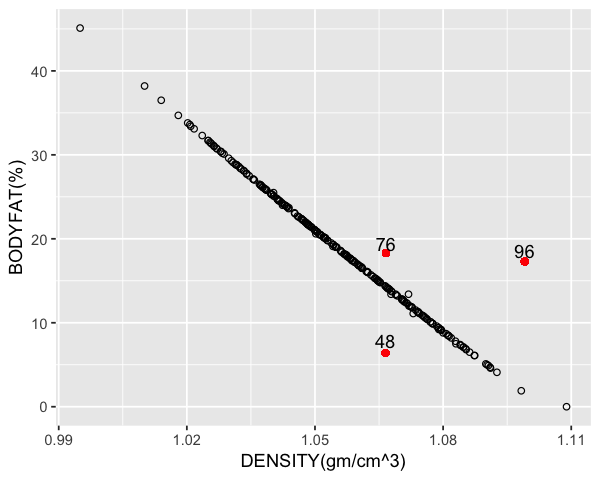

In [17]:
options(repr.plot.width=4, repr.plot.height=3);
pic1<-ggplot(data,aes(x=DENSITY,y=BODYFAT))+geom_point(shape=21)+xlab("DENSITY(gm/cm^3)")+ylab("BODYFAT(%)")+geom_point(aes(x=1.0991,y=17.3),colour="red")+geom_point(aes(x=1.0665,y=6.4),colour="red")+ 
geom_point(aes(x=1.0666,y=18.3),colour="red")+ annotate("text",x=1.0991,y=18.5,label="96")+ annotate("text",x=1.0665,y=7.8,label="48")+annotate("text",x=1.0666,y=19.4,label="76")
print(pic1)

We know that bodyfat~density should looks like a straight line, becasue we just need to retain one variable, so we draw the graph of bodyfat vs density, but we notice that there are 3 points don't lie on the line. The relationship between them is 

$BODYFAT = 495/DENSITY - 450 (1)$


then we use this equation to check which observations are the three outliers by choosing the first three farthest deviate from the line.

Using the equation (1), we can calculate the bodyfat percentage assuming density is correct, and we have:

IDNO | BODYFAT | CAL_BODYFAT
---- | ------- | -----------
96 | 17.3 | 0.37
48 | 6.4 | 14.14
76 | 18.3 | 14.09

We can see the difference is giant, and combine the detail of these three men, we find:  
* for 96: every value is very normal, so we should trust the BODYFAT, the value of DENSITY is likely to be wrong, the original BODYFAT value is kept.  
* for 48: every other value is very normal, but 6.4 BODYFAT is too low for a normal man, so we use Siri function's outcome to replace it.
* for 76: every other value is very normal, the original BODYFAT value is kept.  

In [22]:
data[c(96,48,76),]

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
96,96,17.3,1.0991,53,224.50,77.75,26.1,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8,20.4
48,48,6.4,1.0665,39,148.50,71.25,20.6,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9
76,76,18.3,1.0666,61,148.25,67.50,22.9,36.0,91.6,81.8,94.8,54.5,37.0,21.4,29.3,27.0,18.3


Then we focus on the cook's distance and check which observations are high influence points and check if we need to eliminate them from our model by checking range and the consistency with other variables.

42 
42

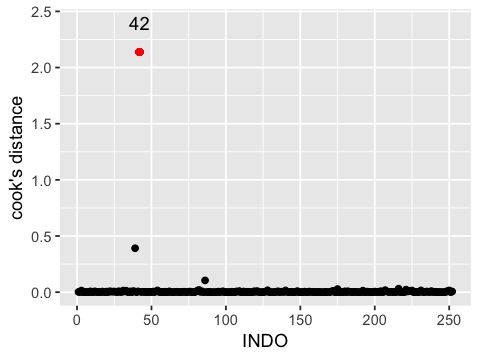

In [44]:
options(repr.plot.width=4, repr.plot.height=3);
m1<-lm(BODYFAT~.,data)#firstly,we build a linear model to check if there is any outliers which need to be eliminated
which.max(cooks.distance(m1))#check the most influence point
d1<-data.frame(index=as.numeric(1:252),cooks=as.numeric(cooks.distance(m1)))
pic2<-ggplot(d1,aes(x=index,y=cooks))+geom_point()+annotate("text",x=42,y=2.4,label="42")+geom_point(x=42,y=2.137609,colour="red")+
xlab("INDO")+ylab("cook's distance")
print(pic2)#we find 42 is a high influence poin

In [32]:
data[42,]#shortest guy

,BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
42,31.7,44,205,29.5,29.9,36.6,106,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4


To determine if wer should retain this point or not, we use the BMI, and we search on google and know that  
*BMI(kg/m^2) = 0.45WEIGHT(lbs) / (0.025HEIGHT(inches))^2* (2)   
then we can calculate the height by assuming WEIGHT and ADIPOSITY is correct, and this man is 70.3 inched tall, so there must be something wrong among these three number, but we cannot decide which is wrong, so just delete it.

39 
39

,BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
39,33.8,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45,29,21.4


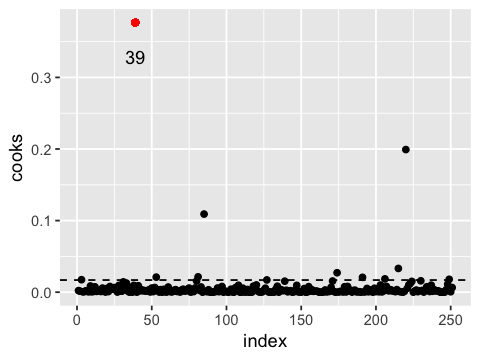

In [48]:
m2<-lm(BODYFAT~.,data)
which.max(cooks.distance(m2))
d2<-data.frame(index=as.numeric(1:251),cooks=as.numeric(cooks.distance(m2)))
pic4<-ggplot(d2,aes(x=index,y=cooks))+geom_point()+annotate("text",x=39,y=0.328,label="39")+geom_point(x=39,y=0.3765567,colour="red")+geom_hline(yintercept=4/(251-15),lty=2)
print(pic4)
data[39,]#this guy is really very fat

To determine if this man's record of WEIGHT is a typo or not, we still use the BMI equation to calculat th WEIGHT by assuming other two values are correct, and we get the WEIGHT = 345.53lbs, which is very close to the record, so this guy is just very fat. From the summary of data, we can see he is so far away from the 3rd quantile, and it will iinfluence our model a lot, so we decide to delete it.

In [59]:
m3<-lm(BODYFAT~.,data)
which.max(cooks.distance(m3))
data[219,]#we reatin it, because his values are all in the range, not extreme value

221 
219

,BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
221,12.7,54,153.25,70.5,24.5,38.5,99,91.8,96.2,57.7,38.1,23.9,31.4,29.9,18.9


For 219, because each value is within the range and quite reasonable, so we choose to retain it. Then we want to check the distrbution of wach variable and see if there is some extreme values in each variable, and detect if there exit some abnormal observations then delete them.

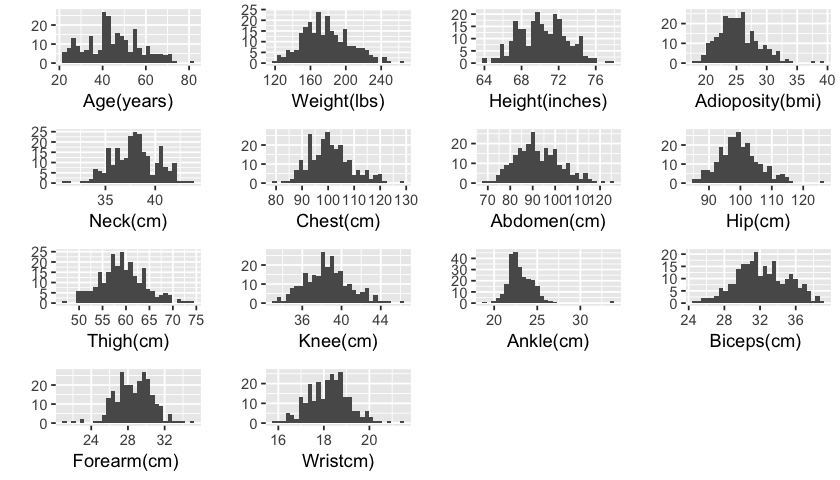

In [58]:
options(repr.plot.width=7, repr.plot.height=4);#Then we want to draw the distribution of each covariates which may be used in our model
p1<-qplot(data$AGE,bins = 30)+xlab("Age(years)");p2<-qplot(data$WEIGHT,bins = 30)+xlab("Weight(lbs)")
p3<-qplot(data$HEIGHT,bins = 30)+xlab("Height(inches)");p4<-qplot(data$ADIPOSITY,bins = 30)+xlab("Adiposity(bmi)")
p5<-qplot(data$NECK,bins = 30)+xlab("Neck(cm)");p6<-qplot(data$CHEST,bins = 30)+xlab("Chest(cm)")
p7<-qplot(data$ABDOMEN,bins = 30)+xlab("Abdomen(cm)");p8<-qplot(data$HIP,bins = 30)+xlab("Hip(cm)")
p9<-qplot(data$THIGH,bins = 30)+xlab("Thigh(cm)");p10<-qplot(data$KNEE,bins = 30)+xlab("Knee(cm)")
p11<-qplot(data$ANKLE,bins = 30)+xlab("Ankle(cm)");p12<-qplot(data$BICEPS,bins = 30)+xlab("Biceps(cm) ")
p13<-qplot(data$FOREARM,bins = 30)+xlab("Forearm(cm) ");p14<-qplot(data$WRIST,bins = 30)+xlab("Wristcm)")
grid.arrange(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,ncol=4)

We notice that in the graph of age, hip and ankle, there are points very far away from other points, so we want to check who are they and if we should eliminate them. Besides, we can see that the adiposity also have 2 outliers, we then need to check who are they.

In [60]:
data[which.max(data$AGE),]
data[which.max(data$HIP),]#he is also the fatest person, but his hip is too big, and this will gain the 
data[data$ANKLE>30,]#They are not very fat, but has a fat ankle, which is abnormal
data<-data[-c(31,40,77,84),]

[1] 40

,BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
79,21.1,81,161.25,70.25,23,37.8,96.4,95.4,99.3,53.5,37.5,21.5,31.4,26.8,18.3


[1] 77

,BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
41,33.1,45,262.75,68.75,39.1,43.2,128.3,126.2,125.6,72.5,39.6,26.6,36.4,32.7,21.4


[1] 40

,BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
31,12.3,32,182,73.75,23.6,38.7,100.5,88.7,99.8,57.5,38.7,33.9,32.5,27.7,18.4
86,25.8,67,167,67.50,26.0,36.5,98.9,89.7,96.2,54.7,37.8,33.7,32.4,27.7,18.2


[1] 31 84

* for the oldest man, because other values are quite normal, but his age is too old, so we decide to delete it.
* for 40, the man whoose hip is big is also the fatest peroson, because he is too fat that we can not use it, because it will make our model not robust and most people can never be that fat.
* for the men who have big ankle, we decide to delete them becaue every other values are not big, and they are not very fat, so the ankle is kiind of abnormal.

,BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
163,13.3,33,184.25,68.75,24.4,40.7,98.9,92.1,103.5,64.0,37.3,23.5,33.5,30.6,19.7
221,12.7,54,153.25,70.50,24.5,38.5,99.0,91.8,96.2,57.7,38.1,23.9,31.4,29.9,18.9


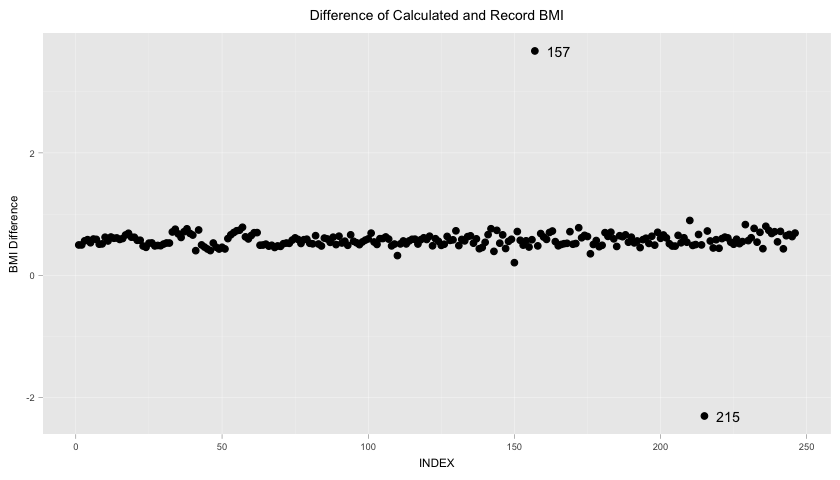

In [78]:
BMI <- (0.45*data$WEIGHT)/((0.025*data$HEIGHT)^2)
diff <- BMI - ADIPOSITY
d <- data.frame(cbind(index = seq(nrow(data)), diff))
pic6<-ggplot(d, aes(index,diff, label = index)) + geom_point() + xlab('INDEX') + ylab('BMI Difference') + theme(text = element_text(size = 7), element_line(size = 0.1), plot.title = element_text(hjust = 0.5))+ 
    geom_text(aes(label = ifelse(abs(diff) > 2, as.character(index),''), hjust = -0.5, vjust = 0.5), size = 3)
print(pic6)
data[c(157,215),]

## 4. variable selection and model building
We can see these two observations are diviate far from the horizontal line, there must be something wrong between height, weight and adiposity but we can not tell what it is, so we just exclude these two observations
After data cleaning process, we have 244 observations and 15 variables in total, and then we will divide them into 5 folds using stratified sampling, and make the size of each fold as equal as possible.  
We order the observations using BODYFAT, and using 5 stratifies to seperatre the data, and gain faive folds:

group | d1 | d2 | d3 | d4 | d5
----- | -- | -- | -- | -- | --
observations | 49 | 49 | 49 | 49 | 48

We will only use this outcome when we choose the best variable selection outcome after choosing by forward, backward, and stepwise selection.

Then we will first using the $train$ method in $caret$ package to using a 10-fold CV to choose the best number of the variable and what are they.

method | nvariable | RMSE | R-Squared | RAE
------ | --------- | ---- | --------- | ---
Backward | 3 | 4.011 | 0.733 | 3.331
Forward | 2| 3.966 | 0.734 | 3.254
Stepwise | 2 | 3.989 | 0.729 | 3.261

The criterion we choose the variable's number is based on the RMSE, R-Squared and RAE by voting.  
From above table, we can see that for each method, the variables number is not too much, I think this might because multicollinaerity exits in our original data, and after we draw the corrplot, we can see the correlation between covariates is very big, so it's very reasonable to have that outcomes. 

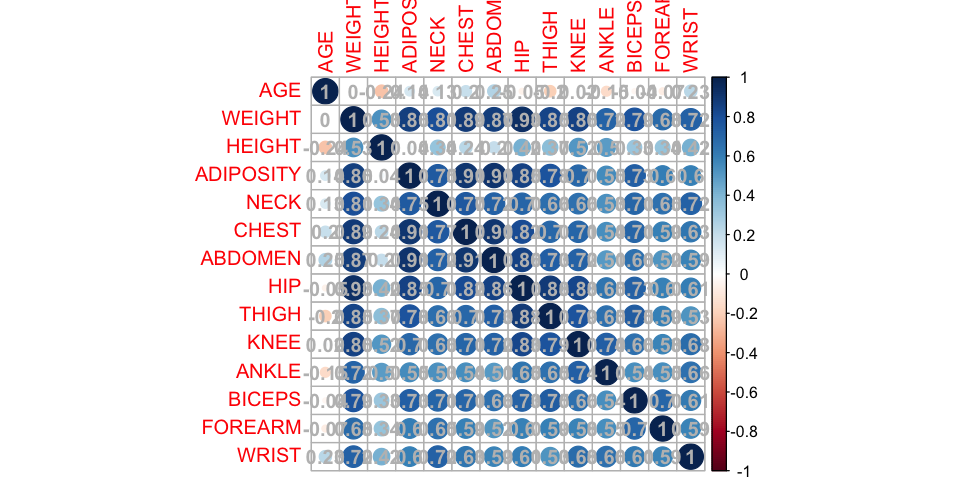

In [98]:
options(repr.plot.width=8, repr.plot.height=4);
corrplot(cor(data[,-1]),addCoef.col = "grey")

Model | AGE | WEIGHT | HEIGHT | NECK | CHEST | ABDOMEN | HIP | THIGH | KNEE | ANKLE | BICEPS | FOREARM | WRIST 
----- | --- | ------ | ------ | ---- | ----- | ------- | --- | ----- | ---- | ----- | ------ | ------- | ----- 
Backward | O | X | O | O | O | X | O | O | O | O | O | O | X 
Forward | O | X| O | O | O | X | O | O | O | O | O | O | O |
Stepwise | O | X | O | O | O | X | O | O | O | O | O | O | O |


As we can see, WEIGHT and ABDOMEN are chosen by all three methods, and Backward selection also select wrist, then we want to use the variable selected and using CV to determine which method should adopte in our fianl model.

Method | MSE
------ | ---
Backward | 16.114
Forward | 16.473
Stepwise | 16.473

Based on the mse calculated, we will choose the variable selected by Backward selection as our final model.

Our final model is  
 
                     BODYFAT = -28.29794 -0.09519*WEIGHT + 0.89934*ABDOMEN - 1.03389*WRIST
* The p-value of our model is < 2.2e-16, which is very significant against the null hypothesis that the coefficients are 0.
* Our adjusted R-squared is 0.9593, which means our fitting is quite good

## 5. model diagnostic

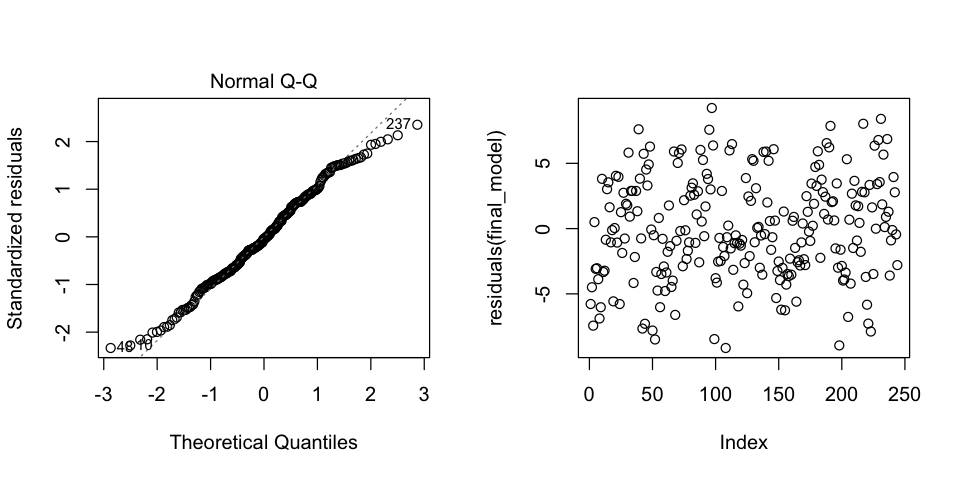

In [111]:
par(mfrow=c(1,2))
plot(final_model,which=2)
plot(residuals(final_model))
par(mfrow=c(1,1))

* Normality assumption: the points fall on the line which means standardized residual follows standard normal distribution.
* Homoscedasticity: from the residual plot, there is no wried pattern and the points are randomly dispersed around the horizontal axis y=0, thus the linear regression model seems to be appropriate for the data.
* Multi-colinearity: use $vif$ function to check multicollinearity between the variables selected. If the number is less than 10, we assume no significant multicollinearity among these variables, and we can see our model doesn't have multi-colinearity issue.

Variable | Vif
-------- | ---
WEIGHT | 5.777
ABDOMEN | 4.233
WRIST | 2.116

# 6. conclusion

**Possible rule of thumb :** 

Your abdomen circumference (cm) multiply by 0.90 minus wrist circumference (cm) multiply by 1.03 minus weight (lbs) multiply by 0.10 minus 28

**strength and weakness :**
* **Simple to interpret**: because our model is just a linear model which only involves 3 covariates, so it's quite simple to understand.
* **Robust**: we use stratified sampling and cross validation in the model building process, which can minimize the influence caused by the uncertainty in the data, and can avoid overfitting. Besides, we have do lots of work in data cleaning part, we get rid of all the abnormal points which will bring bias to our model. And as you can see from the model diagnostic graph, our model satisfies all the assumption and fits well.
* It might be diificult to understand why the coefficients of WEIGHT and WRIST is negative.
